In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Specify column names
column_names = ['Review', 'Label']

# Read in txt files and set column headers
amazon = pd.read_csv('amazon_cells_labelled.txt', delimiter='\t', header=None, names=column_names)
print(f'Amazon shape: {amazon.shape}')
imdb = pd.read_csv('imdb_labelled.txt', delimiter='\t', header=None, names=column_names)
print(f'IMDB shape: {imdb.shape}')
yelp = pd.read_csv('yelp_labelled.txt', delimiter='\t', header=None, names=column_names)
print(f'Yelp shape: {yelp.shape}')

Amazon shape: (1000, 2)
IMDB shape: (748, 2)
Yelp shape: (1000, 2)


In [3]:
# Concatenate the three dataframes together
df = pd.concat([amazon, imdb, yelp], ignore_index=True)

In [4]:
# Check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  2748 non-null   object
 1   Label   2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB


In [5]:
# Check Label to make sure values look appropriate
df['Label'].value_counts()

Label
1    1386
0    1362
Name: count, dtype: int64

# Applying Lowercase and Remove Punctuation

In [6]:
print('Before any preprocessing:')
print(df['Review'].iloc[1898])
print()

# Set 'Review' to lowercase
df['Review'] = df['Review'].str.lower()

print('After applying lowercase:')
print(df['Review'].iloc[1898])
print()

# Remove punctuation (Sewell, Web6)
pattern = re.compile(r'[^\w\s]')
df['Review'] = df['Review'].apply(lambda x: pattern.sub('', x))
print('After removing punctuation:')
print(df['Review'].iloc[1898])

Before any preprocessing:
My fiancé and I came in the middle of the day and we were greeted and seated right away.

After applying lowercase:
my fiancé and i came in the middle of the day and we were greeted and seated right away.

After removing punctuation:
my fiancé and i came in the middle of the day and we were greeted and seated right away


In [7]:
print('Before removing special characters:')
print(df['Review'].iloc[1898])
print()

# Remove special characters
pattern = re.compile(r'[^A-Za-z0-9\s]')
df['Review'] = df['Review'].apply(lambda x: pattern.sub('', x))

print('After removing special characters:')
print(df['Review'].iloc[1898])

Before removing special characters:
my fiancé and i came in the middle of the day and we were greeted and seated right away
Before removing special characters:
my fianc and i came in the middle of the day and we were greeted and seated right away


# Tokenization, Stop words, and Lemmatization

In [8]:
# Tokenize and remove stop words (Sewell, Web6)
print('Before tokenizing and applying stopwords:')
print(df['Review'].iloc[1898])
print()

# Download stop word list
stop_words = set(stopwords.words('english'))

# Create empty list
data_set = []

# Tokenize each word in sentence and remove stop words
for sentence in df['Review']:
    data_set.append([word for word in word_tokenize(sentence) if word not in stop_words])

# Assign list back to dataframe
df['Review'] = data_set

print('After tokenizing and applying stopwords:')
print(df['Review'].iloc[1898])

Before tokenizing and applying stopwords:
my fianc and i came in the middle of the day and we were greeted and seated right away

After tokenizing and applying stopwords:
['fianc', 'came', 'middle', 'day', 'greeted', 'seated', 'right', 'away']


In [9]:
from nltk.stem import PorterStemmer
# Initialize PorterStemmer object
stemmer = PorterStemmer()

# Create a function to stem tokenized text
def stem_tokens(token_list):
    return [stemmer.stem(word) for word in token_list]

# Apply function to text
print('Before Stemming:')
#print(df['Review'].iloc[0])
print(df['Review'].iloc[1898])
print()

df['Review'] = df['Review'].apply(stem_tokens)

print('After Stemming:')
#print(df['Review'].iloc[0])
print(df['Review'].iloc[1898])

Before Stemming:
['fianc', 'came', 'middle', 'day', 'greeted', 'seated', 'right', 'away']

After Stemming:
['fianc', 'came', 'middl', 'day', 'greet', 'seat', 'right', 'away']


In [10]:
# # Apply Lemmatizer (Sewell, Web6)
# print('Before Lemmatization:')
# print(df['Review'].iloc[0])
# print()

# # Initialize Lemmatizer object
# lemmatizer = WordNetLemmatizer()

# # Create a function to lemmatize text
# def lem(token_text):
#     text = [lemmatizer.lemmatize(word) for word in token_text]
#     return text

# # Apply function to text
# df['Review'] = df['Review'].apply(lem)

# print(f'After Lemmatization:')
# print(df['Review'].iloc[0])

# Determine Vocabulary Size

Word Index Length: 4175


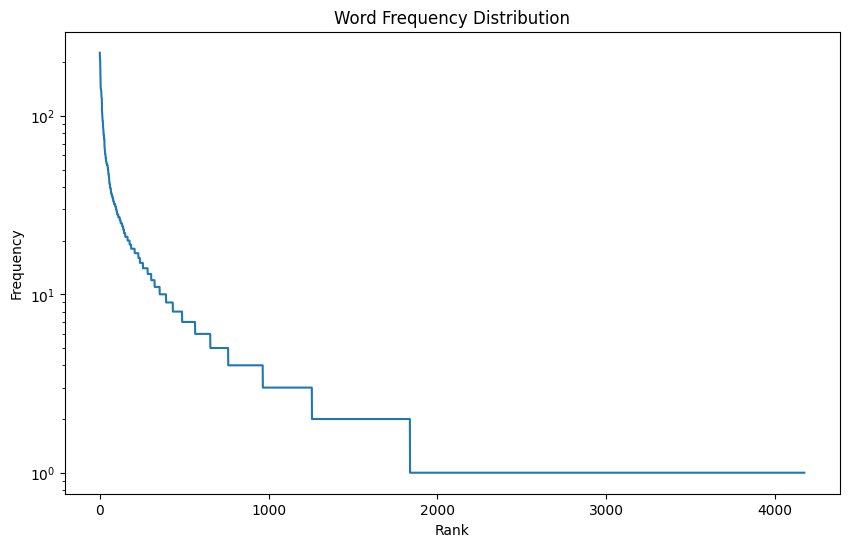

Suggested vocabulary size (covering 95.0% of occurrences): 3233


In [11]:
# Tokenize the text and build the vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])

# Get the word index and word counts
word_index = tokenizer.word_index
print(f'Word Index Length: {len(word_index)}')
word_counts = tokenizer.word_counts

# Convert word_counts to a DataFrame for analysis
word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['word', 'count'])
word_counts_df = word_counts_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# Plot the word frequency distribution
plt.figure(figsize=(10, 6))
plt.plot(word_counts_df['count'].values)
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution')
plt.show()

# Determine the cumulative coverage of word counts
word_counts_df['cumulative_count'] = word_counts_df['count'].cumsum()
total_count = word_counts_df['count'].sum()
word_counts_df['coverage'] = word_counts_df['cumulative_count'] / total_count

# Choose a vocabulary size that covers a high percentage of the total occurrences (e.g., 95%)
coverage_threshold = 0.95
vocab_size = word_counts_df[word_counts_df['coverage'] >= coverage_threshold].index[0] + 1
print(f'Suggested vocabulary size (covering {coverage_threshold*100}% of occurrences): {vocab_size}')

# Apply the chosen vocabulary size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['Review'])
sequences = tokenizer.texts_to_sequences(df['Review'])

# Vectorization

In [13]:
# Vectorization (Sewell, Web6)
print('Before vectorizing for model:')
print(df['Review'].iloc[1898])
print()

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df['Review'])
sequences = tokenizer.texts_to_sequences(df['Review'])

print('After vectorizing for model:')
print(sequences[1898])

Before vectorizing for model:
['fianc', 'came', 'middl', 'day', 'greet', 'seat', 'right', 'away']

After vectorizing for model:
[100, 112, 1770, 350, 82, 277]


# Determine Max Length For Padding

count    2748.000000
mean        6.514556
std        19.893404
min         0.000000
25%         3.000000
50%         5.000000
75%         8.000000
max       789.000000
dtype: float64


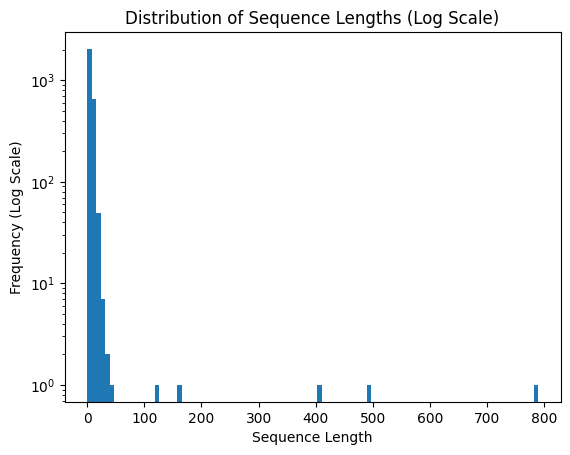

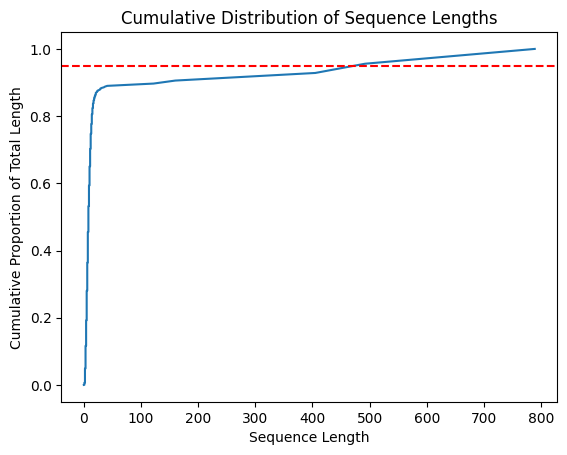

Suggested max_length (95th percentile): 492
Chosen max_length: 492


In [14]:
# Calculate the lengths of the sequences
lengths = [len(seq) for seq in sequences]

# Describe the lengths
lengths_series = pd.Series(lengths)
print(lengths_series.describe())

# Plot the distribution of sequence lengths
plt.hist(lengths, bins=100, log=True)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency (Log Scale)')
plt.title('Distribution of Sequence Lengths (Log Scale)')
plt.show()

# Plot the cumulative distribution
sorted_lengths = sorted(lengths)
cumulative_lengths = [sum(sorted_lengths[:i+1])/sum(sorted_lengths) for i in range(len(sorted_lengths))]

plt.plot(sorted_lengths, cumulative_lengths)
plt.xlabel('Sequence Length')
plt.ylabel('Cumulative Proportion of Total Length')
plt.title('Cumulative Distribution of Sequence Lengths')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()

# Decide on max_length based on cumulative distribution (e.g., 95th percentile)
for i, cumulative_proportion in enumerate(cumulative_lengths):
    if cumulative_proportion >= 0.95:
        max_length = sorted_lengths[i]
        break

print(f'Suggested max_length (95th percentile): {max_length}')

# Alternatively, use a specific value based on observation
max_length = int(max_length)  # Ensure it's an integer
print(f'Chosen max_length: {max_length}')

# Apply Padding

In [15]:
# Pad Sequences (Sewell, Web6)
print('Before padding:')
print(sequences[0])
print()

X = pad_sequences(sequences, maxlen = max_length, padding='post')

print('After padding:')
print(X[0])

Before padding:
[52, 230, 120, 566, 17, 1839]

After padding:
[  52  230  120  566   17 1839    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0

# Implement Model

In [16]:
y = df['Label'].values

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Original shape: {df.shape}')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Original shape: (2748, 2)
(2198, 492)
(550, 492)
(2198,)
(550,)


In [28]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping


embedding_vector_length = 300
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# # Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.4732 - loss: 0.6974 - val_accuracy: 0.5091 - val_loss: 0.6930
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.4831 - loss: 0.6974 - val_accuracy: 0.5091 - val_loss: 0.6942
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.5093 - loss: 0.6951 - val_accuracy: 0.5091 - val_loss: 0.6930
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.4790 - loss: 0.6964 - val_accuracy: 0.5091 - val_loss: 0.6932
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.5205 - loss: 0.6917 - val_accuracy: 0.4932 - val_loss: 0.6940
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.5141 - loss: 0.6939 - val_accuracy: 0.5091 - val_loss: 0.6932
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4422 - loss: 0.6947
Test Accuracy: 0.47090908885002136


In [29]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

embedding_vector_length = 300
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length))
model.add(SpatialDropout1D(0.3))

# Adding more LSTM layers with bidirectional wrapping
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.3)))

# Adding more dense layers with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Final output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

print()
print()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5254 - loss: 0.6927 - val_accuracy: 0.5068 - val_loss: 0.6926
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.5182 - loss: 0.6944 - val_accuracy: 0.5091 - val_loss: 0.6923
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.5183 - loss: 0.6928 - val_accuracy: 0.5091 - val_loss: 0.6911
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.5205 - loss: 0.6922 - val_accuracy: 0.5091 - val_loss: 0.6874
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.5479 - loss: 0.6849 - val_accuracy: 0.7341 - val_loss: 0.6609
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.6707 - loss: 0.6325 - val_accuracy: 0.7386 - val_loss: 0.4980
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.8411 - loss: 0.4165 - val_accuracy: 0.7682 - val_loss: 0.4629
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.9050 - loss: 0.2979 - val_accuracy: 0.7591 - val_loss:

In [33]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

embedding_vector_length = 300
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length))
model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

print()
print()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.5103 - loss: 12.8838 - val_accuracy: 0.5409 - val_loss: 12.2089
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5059 - loss: 12.3271 - val_accuracy: 0.5409 - val_loss: 11.7007
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.5089 - loss: 11.7831 - val_accuracy: 0.4932 - val_loss: 11.2241
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5178 - loss: 11.3060 - val_accuracy: 0.4909 - val_loss: 10.7771
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.4863 - loss: 10.8884 - val_accuracy: 0.4955 - val_loss: 10.3572
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.4830 - loss: 10.4550 - val_accuracy: 0.4977 - val_loss: 9.9731
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5001 - loss: 10.1090 - val_accuracy: 0.5000 - val_loss: 9.6207
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.4875 - loss: 9.7456 - val_accuracy: 0.5114

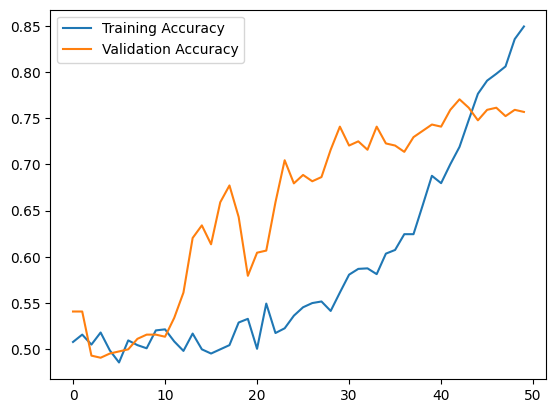

In [34]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

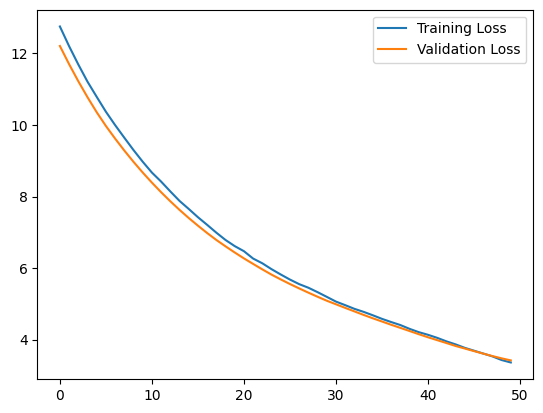

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [30]:
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 492, 300)            │         969,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_4                  │ (None, 492, 300)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 492, 200)            │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100)                 │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,199,033 (16.02 MB)

 Trainable params: 1,399,677 (5.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,799,356 (10.68 MB)

None


In [21]:
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping



# # Build the model with additional layers
# model = Sequential()
# model.add(Embedding(input_dim=50000, output_dim=128, input_length=max_length))
# model.add(LSTM(units=128, return_sequences=True))  # Return sequences to feed into the next LSTM layer
# model.add(LSTM(units=128))
# model.add(Dense(units=64, activation='relu'))  # Add a Dense layer with ReLU activation
# #model.add(Dropout(0.5))  # Add Dropout for regularization
# model.add(Dense(units=1, activation='sigmoid'))  # Use sigmoid activation for binary classification

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the model with early stopping
# model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy}')